# **Введение**
В данном проекте исследуются бизнес-метрики развлекательного приложения **Procrastinate Pro+**.\
Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

**Задача** — разобраться в причинах и помочь компании выйти в плюс.\
\
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.\
\
Необходимо изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

# **1. Загрузка данных и подготовка к анализу**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta as dt
from matplotlib import pyplot as plt

costs = pd.read_csv('/datasets/costs_info_short.csv')   # рекламные расходы
orders = pd.read_csv('/datasets/orders_info_short.csv') # выгрузка их покупок за этот период
visits = pd.read_csv('/datasets/visits_info_short.csv') # лог сервера с данными об их посещениях

In [2]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [3]:
costs.head(5)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [4]:
costs.duplicated().sum() # проверка на дубликаты

0

В costs пропусков данных нет. Дубликатов строк нет. Преобразуем данные о дате. Формат остальных данных удовлетворителен для дальнейшей работы. Для удобства приведём наименования столбцов к нижнему регистру.

In [5]:
costs.columns = costs.columns.str.lower()
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [6]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [9]:
orders.duplicated().sum()

0

В orders пропусков данных нет. Дубликатов строк нет. Преобразуем данные о дате-времени. Формат остальных данных удовлетворителен для дальнейшей работы. Для удобства приведём наименования столбцов к нижнему регистру и заменим пробелы на нижние подчёркивания.

In [10]:
orders.columns = orders.columns.str.lower().str.replace(' ','_')
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [11]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [12]:
orders['revenue'].value_counts()

4.99     38631
5.99       780
9.99       385
49.99      212
19.99      204
Name: revenue, dtype: int64

In [13]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [14]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [15]:
visits.duplicated().sum()

0

В visits пропусков данных нет. Дубликатов строк нет. Преобразуем данные о дате-времени. Формат остальных данных удовлетворителен для дальнейшей работы. Для удобства приведём наименования столбцов к нижнему регистру и заменим пробелы на нижние подчёркивания.

In [16]:
visits.columns = visits.columns.str.lower().str.replace(' ','_')
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [17]:
visits['session_start'] = pd.to_datetime(visits['session_start'])

Данные подготовлены для дальнейшего анализа.

# **2. Задание функций для расчета и анализа LTV, ROI, удержания и конверсии**

## 2.1 Функция для создания пользовательских профилей *get_profiles()*

In [18]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

## 2.2 Функция для расчёта удержания *get_retention()*

In [19]:
# функция для расчёта удержания

def get_retention(
    profiles,
    visits,
    observation_day,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_day
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_day - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

## 2.3 Функция для расчёта конверсии *get_conversion()*

In [20]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    orders,
    observation_day,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_day
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_day - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

## 2.4 Функция для расчёта LTV и ROI *get_ltv()*

In [21]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_day,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_day
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_day - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

## 2.5 Функция визуализации удержания *plot_retention()*

In [22]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [23]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

## 2.6 Функция визуализации конверсии *plot_conversion()*

In [24]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## 2.7 Функция визуализации LTV и ROI *plot_ltv_roi()*

In [25]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# **3. Исследовательский анализ данных**

## 3.1. Создание пользовательских профилей. Определение минимальной и максимальной даты привлечения пользователей.

In [26]:
# создание пользовательских профилей
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [27]:
# определение минимальной даты привлечения пользователей
profiles['dt'].min()

datetime.date(2019, 5, 1)

In [28]:
# определение максимальной даты привлечения пользователей
profiles['dt'].max()

datetime.date(2019, 10, 27)

Интервал дат в данных с 01.05.2019 г. по 27.10.2019 г., что соответствует требованиям к исследованию.

## 3.2. Количество пользователей и доля платящих из каждой страны.

In [29]:
pay_profiles = profiles.pivot_table(index='region', columns='payer', values='user_id', aggfunc='count')\
                       .rename(columns={False:"unpay",True:"pay"})
pay_profiles['total'] = pay_profiles['unpay'] + pay_profiles['pay']
pay_profiles['payer_percent'] = profiles.groupby(['region']).agg({'payer':'mean'}) * 100
pay_profiles.sort_values('pay', ascending=False)


payer,unpay,pay,total,payer_percent
region,,,,
United States,93100,6902,100002,6.901862
UK,16875,700,17575,3.982930
France,16787,663,17450,3.799427
Germany,14365,616,14981,4.111875


В имеющемся датасете содержится информация о пользователях из США, Великобритании, Франции и Германии. Наибольшее количество платящих пользователей приходят из США - 6902 пользователя, что составляет около 7% от пользователей США. На втором месте Великобритания, где таких пользователей в 10 раз меньше - 700 (4% от пользователей UK). Примерно столько же в количественном и процентном выражении во Франции и Германии.

## 3.3. Количество пользователей и доля платящих для каждого устройства.

In [30]:
dev_profiles = profiles.pivot_table(index='device', columns='payer', values='user_id', aggfunc='count')\
                       .rename(columns={False:"unpay",True:"pay"})
dev_profiles['total'] = dev_profiles['unpay'] + dev_profiles['pay']
dev_profiles['payer_percent'] = profiles.groupby(['device']).agg({'payer':'mean'}) * 100
dev_profiles.sort_values('pay', ascending=False)

payer,unpay,pay,total,payer_percent
device,,,,
iPhone,51097,3382,54479,6.207897
Android,32982,2050,35032,5.851793
Mac,28130,1912,30042,6.364423
PC,28918,1537,30455,5.046790


Пользователи приложения используют устройства Мас и iPhone, устройства на базе Android и персональные компьютеры. Наибольшее количество платящих пользователей используют iPhone. Примерно одинаковое количество платящих пользователей используют Android и Mac - 2050 и 1912 соответственно. Наименьшее количество платящих пользователей среди использующих PC.

## 3.4. Количество пользователей и долю платящих для каждого канала привлечения.

In [31]:
chan_profiles = profiles.pivot_table(index='channel', columns='payer', values='user_id', aggfunc='count')\
                        .rename(columns={False:"unpay",True:"pay"})
chan_profiles['total'] = chan_profiles['unpay'] + chan_profiles['pay']
chan_profiles['payer_percent'] = profiles.groupby(['channel']).agg({'payer':'mean'}) * 100
chan_profiles.sort_values('pay', ascending=False)

payer,unpay,pay,total,payer_percent
channel,,,,
FaceBoom,25587,3557,29144,12.204914
TipTop,17683,1878,19561,9.600736
organic,55279,1160,56439,2.055316
WahooNetBanner,8100,453,8553,5.296387
AdNonSense,3440,440,3880,11.340206
RocketSuperAds,4096,352,4448,7.913669
LeapBob,8291,262,8553,3.063253
OppleCreativeMedia,8372,233,8605,2.707728
lambdaMediaAds,1924,225,2149,10.469986


Наибольшее количество платящих пользователей было привлечено через канал FaceBoom - 3557, на втором месте TipTop - 1878, и пользователи, которые сами нашли приложение - 1160. На тертьем месте с двоиным отставанием - WahooNetBanner.

# **4. Маркетинг**

## 4.1. Расходы на маркетинг. Распределение трат по источникам. Визуализация изменения метрик во времени.

In [32]:
# общая сумма расходов на маркетинг
total_costs = costs['costs'].sum().round(2)
total_costs

105497.3

In [33]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values('costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Самые большие траты на привлечение пользователей были совершены на каналы TipTop (54751,3) и FaceBoom (32445,6). На третьем месте WahooNetBanner с затратами 5151,0.

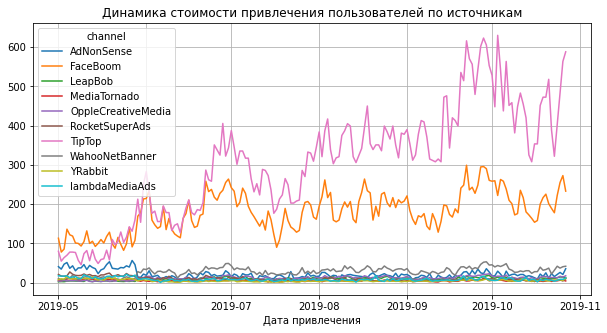

In [34]:
costs.pivot_table(
    index='dt', columns='channel', values='costs', aggfunc='sum'
).plot(
    grid=True, figsize=(10,5))
plt.xlabel('Дата привлечения')
plt.title('Динамика стоимости привлечения пользователей по источникам')
None

Из графика видно значительно преобладание трат на TipTop и FaceBoom. Траты на TipTop постепенно возрастают с течением времени. Для этого графика характерны пиковые значения с периодичностью в один месяц. С такой же периодичностью наблюдаются пиковые значения трат на FaceBoom, но аплитуда колебаний трат на него меньше и они стабильнее во времени, явного роста не наблюдается. Динамика по остальным каналам представлена на графике ниже.

In [35]:
low_costs = costs.query('channel != "FaceBoom" and channel != "TipTop"').pivot_table(
    index='dt', columns='channel', values='costs', aggfunc='sum'
)
low_costs

channel,AdNonSense,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,WahooNetBanner,YRabbit,lambdaMediaAds
dt,,,,,,,,
2019-05-01,40.95,2.52,6.24,4.25,21.060,10.8,8.10,17.6
2019-05-02,34.65,2.94,5.04,4.25,16.965,7.2,9.90,16.8
2019-05-03,47.25,2.73,6.96,5.75,16.380,8.4,9.00,16.8
2019-05-04,51.45,3.99,9.36,4.25,17.550,10.8,15.60,17.6
2019-05-05,36.75,4.62,11.04,5.50,27.495,12.0,9.60,12.8
...,...,...,...,...,...,...,...,...
2019-10-23,15.75,10.71,5.28,13.25,5.525,31.8,6.48,4.0
2019-10-24,21.00,12.81,5.04,12.50,5.850,42.0,7.29,6.4
2019-10-25,26.25,14.70,6.24,16.50,7.150,37.2,7.56,8.8


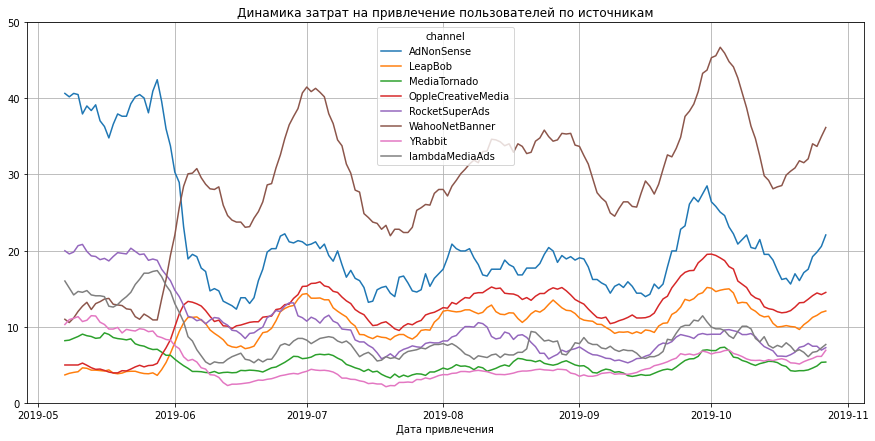

In [36]:
report_filtered = low_costs.copy()

for column in low_costs.columns.values:
    report_filtered[column] = report_filtered[column].rolling(7).mean()

report_filtered.plot(
    grid=True, figsize=(15,7), ylim=(0,50))
plt.xlabel('Дата привлечения')
plt.title('Динамика затрат на привлечение пользователей по источникам')
None

Аналогичная картина наблюдается для остальных каналов с меньшими затратами: пиковые значения трат на привлечение пользователей совпадают и имеют периодичность в один месяц, незначительный рост трат в долгосрочном периоде. Подобная картина говорит об одновременном проведении рекламных кампаний по всей группе каналов с различным бюджетом на каждый.

## 4.2 Средняя стоимость привлечения одного пользователя из каждого источника. Средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

In [37]:
# Средняя стоимость привлечения одного пользователя из каждого источника
channel_cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost':'mean'})
    .sort_values('acquisition_cost', ascending=False)
    .rename(columns={'acquisition_cost': 'cac'})
)
channel_cac

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


In [38]:
# Средний CAC на одного пользователя для всего проекта
costs['costs'].sum()/profiles.query('channel != "organic"')['user_id'].nunique()

1.127481323942759

Средняя стоимость привлечения одного пользователя из канала TipTop (2,799) значительно отличается от второго по стоимости канала (FaceBoom - 1,113), остальных каналов (1,008 и меньше) и от среднего САС всего проекта - 1,127.\
Дороже всего обходятся пользователи из TipTop.

# **5. Окупаемость рекламы**

Для анализа принимается, что дата формирования отчёта - 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

In [39]:
costs['costs'].sum()

105497.30000000002

## 5.1. Общая окупаемость рекламы. Графики LTV и ROI. Графики динамики LTV, CAC и ROI.

In [40]:
observation_day = datetime(2019, 11, 1).date() # момент анализа
horizon_days = 14 # горизонт анализа 

In [41]:
from datetime import datetime, timedelta

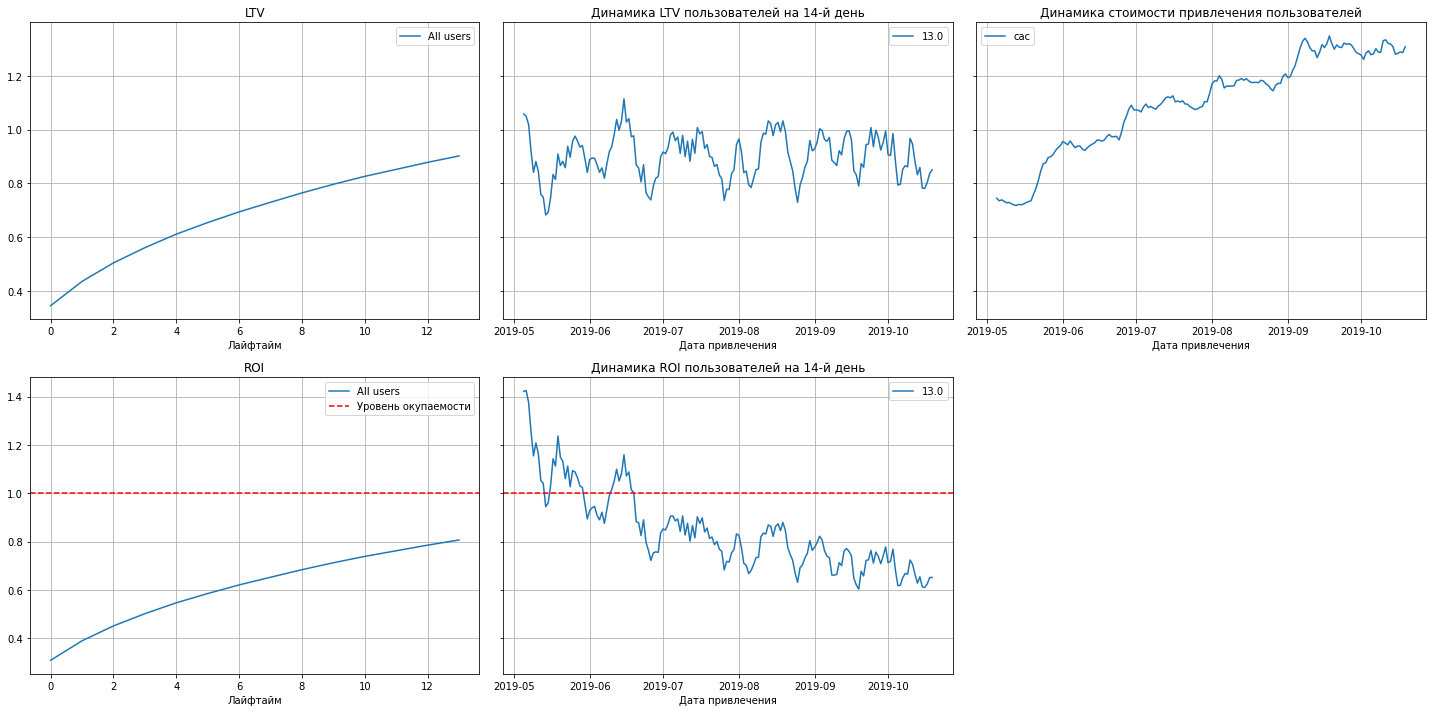

In [42]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    orders,
    observation_day,
    horizon_days,
    dimensions=[],
    ignore_horizon=False)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=5)

Из этих графиков видно:
* Реклама не окупается. ROI в конце второй недели — едва преодолевает отметку в 80%.
* CAC растёт: резкий рост к июню на 0,3 пункта и дальнейший рост ещё почти на 0,3 пункта за 4 месяца. Рекламный бюджет увеличивают.
* LTV стабилен, значит качесво пользователей не ухудшается.
* Динамика ROI отрицательная. Действительно, ведь LTV стабилен, а CAC растёт. ROI = LTV / CAC, при такой зависимости падение окупаемости закономерно и обусловлено увеличением бюджета на рекламу без увеличения качества пользователей.

## 5.2. Окупаемость рекламы с разбивкой по рекламным каналам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

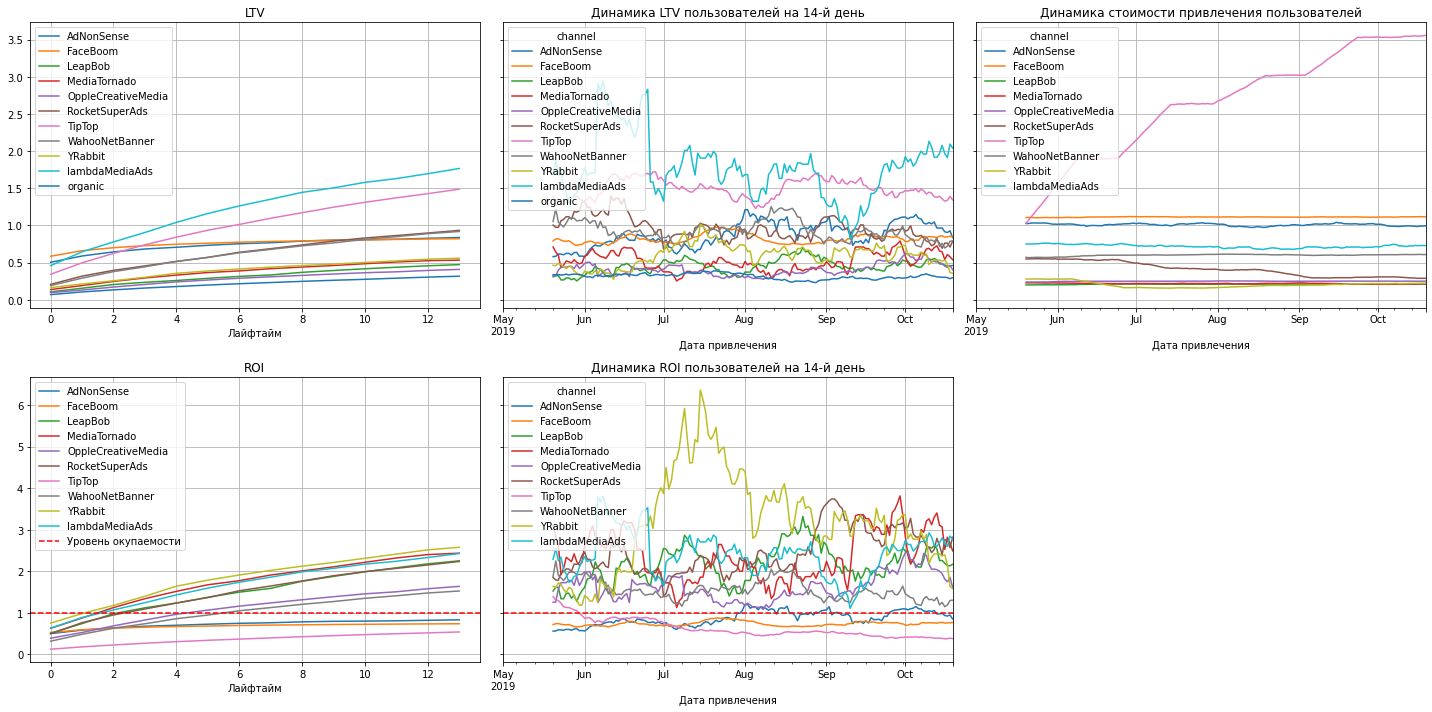

In [43]:
dimensions = ['channel']
ltw_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_day, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=20)

Из графиков видно:
* Наиболее качественные пользователи привлечены каналами lambdaMediaAds и TipTop.
* Динамика LTV каналов относительна стабильна, резкого роста или падения не наблюдается. Наименее нестаблильным выглядит lambdaMediaAds, но и он на большем промежутке времени не превышает двух пунктов.
* Динамика стоимости привлечения пользователей стабильная для большинства каналов, кроме TipTop. Он имеет быстрый рост от 1 до 3,5 пунктов за 6 месяцев. Также небольшое снижение стоимости с ~0,55 до 0,3 наблюдатся у канала RocketSuperAds.
* Окупаемость пользователей к 14 дню для большинства каналов имеет хорошие показатели от 1,5 до 2,6. Не окупается привлечение пользователей из трёх каналов: AdNonSense, FaceBoom, TipTop.
* Динамика ROI относительно стабильна для большинства каналов. YRabbit имеет скачок в период 2019-07 - 2019-08, в дальнейшем - стабилен.

## 5.3. Окупаемость рекламы с разбивкой по странам.Графики LTV и ROI, а также графики динамики LTV, CAC и ROI. Обнаруженные проблемы.

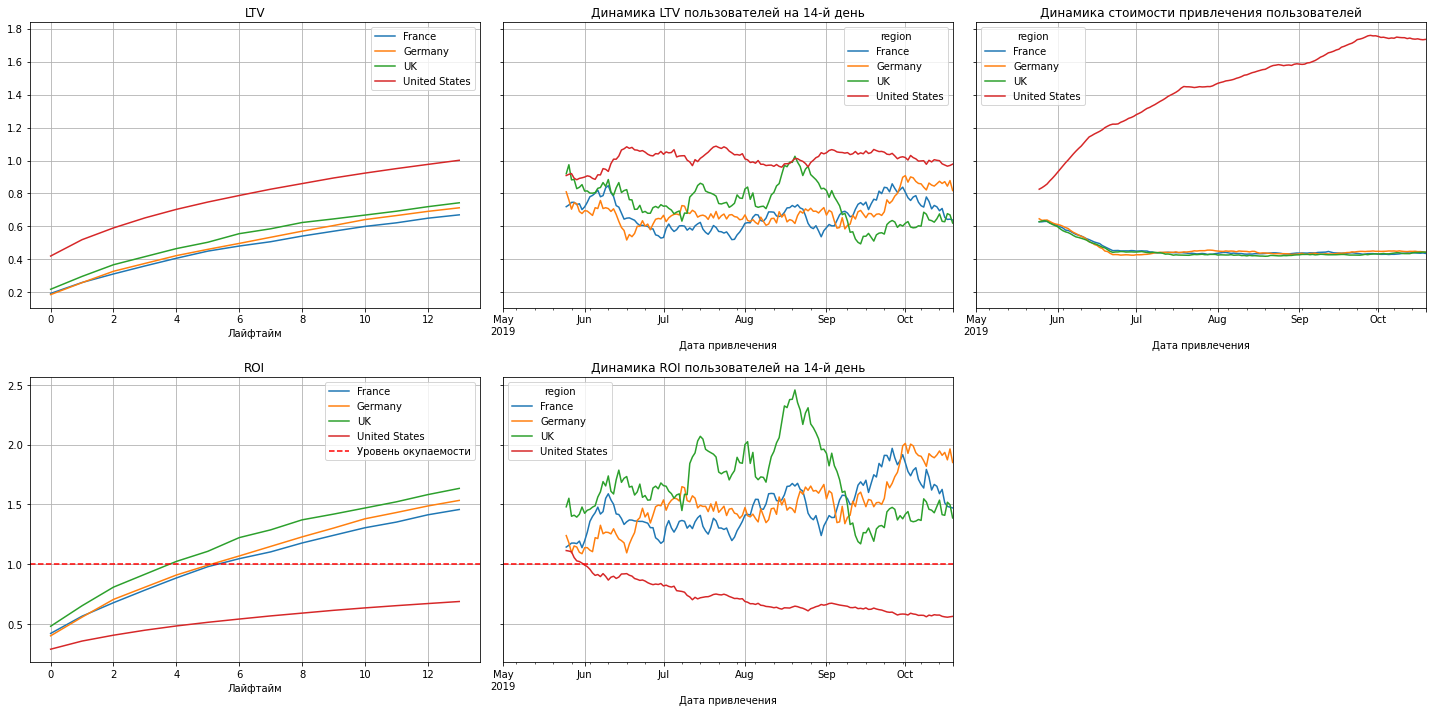

In [44]:
dimensions = ['region']
ltw_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles.query('channel != "organic"'), orders, observation_day, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=25)

Из графиков видно:
* Наиболее качественные пользователи приходят из США, но при этом их привлечение не окупается к 14 дню, ввиду высокой стоимости на рекламу. При этом окупаемость имела место до июня. Затем, в июне месяце, окупаемаесть начала падать вместе с ростом трат на рекламу. В июле пользователи из США перестали окупаться.
* Пользователи из Франции, Германии и Великобритании имеют меньший LTV, имеют стабильный и невысокий САС по сравнению с США (около 0,3 против 1,75 в октябре) и показывают хорошие результаты окупаемости на 14 день - 1,7-2,1. Привлечение пользователей из США обходится значительно дороже.

## 5.4 Окупаемость рекламы с разбивкой по устройствам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

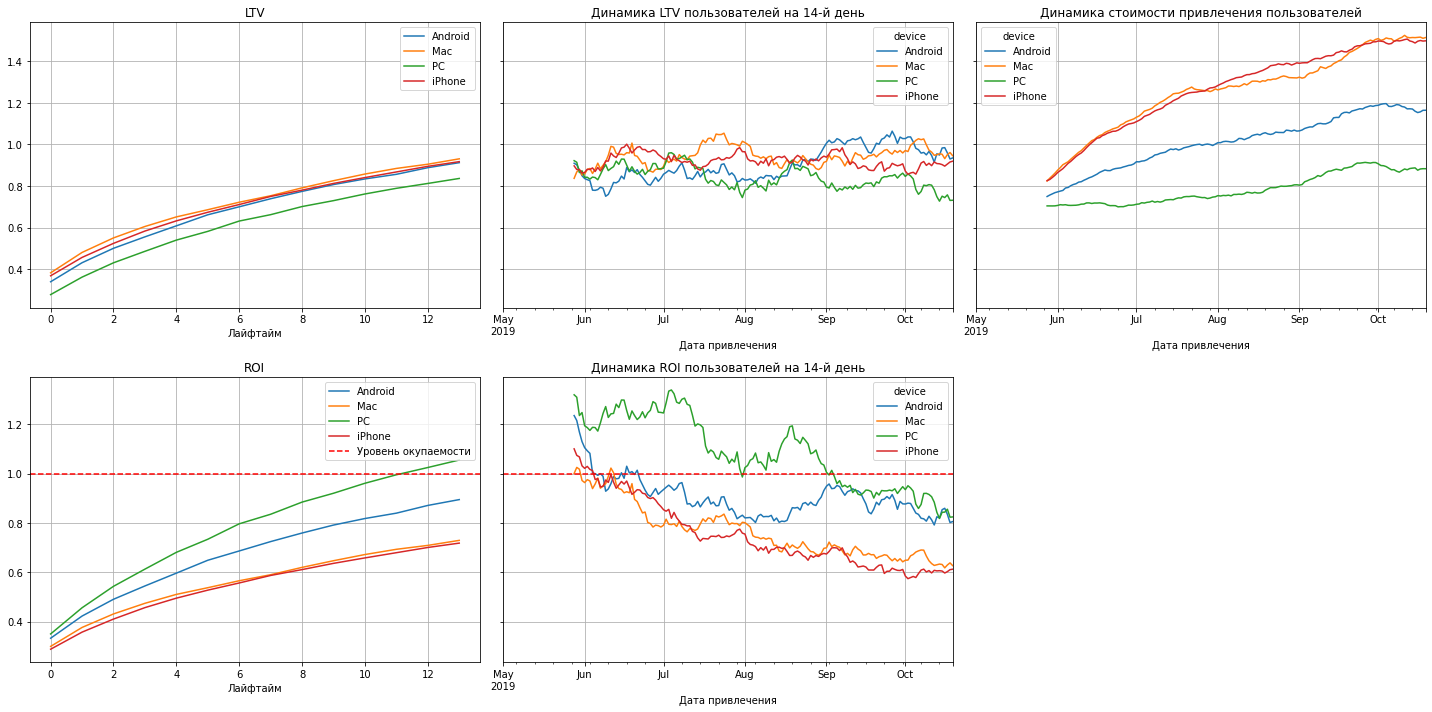

In [45]:
dimensions = ['device']
ltw_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles.query('channel != "organic"'), orders, observation_day, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=28)

Из графиков видно:
* Качество пользователей примерно одинаковое для всех устройств и стабильно, лишь немного отстают пользователи ПК.
* К 14 дню окупились только пользователи PC. Пользователи Android, Mac и iPhone так и не окупились.
* Стоимость привлечения пользователей Mac и iPhone растет примерно одинаково и быстрее, чем Android и PC. Этот рост оказывает влияние на ROI, который падает. В июне пользователи Android, Mac и iPhone перестали окупаться, PC перестаёт окупаться в сентябре.\
\
Стабильный LTV и увеличение затрат на рекламу CAC привели к падению ROI.

## 5.5. Графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

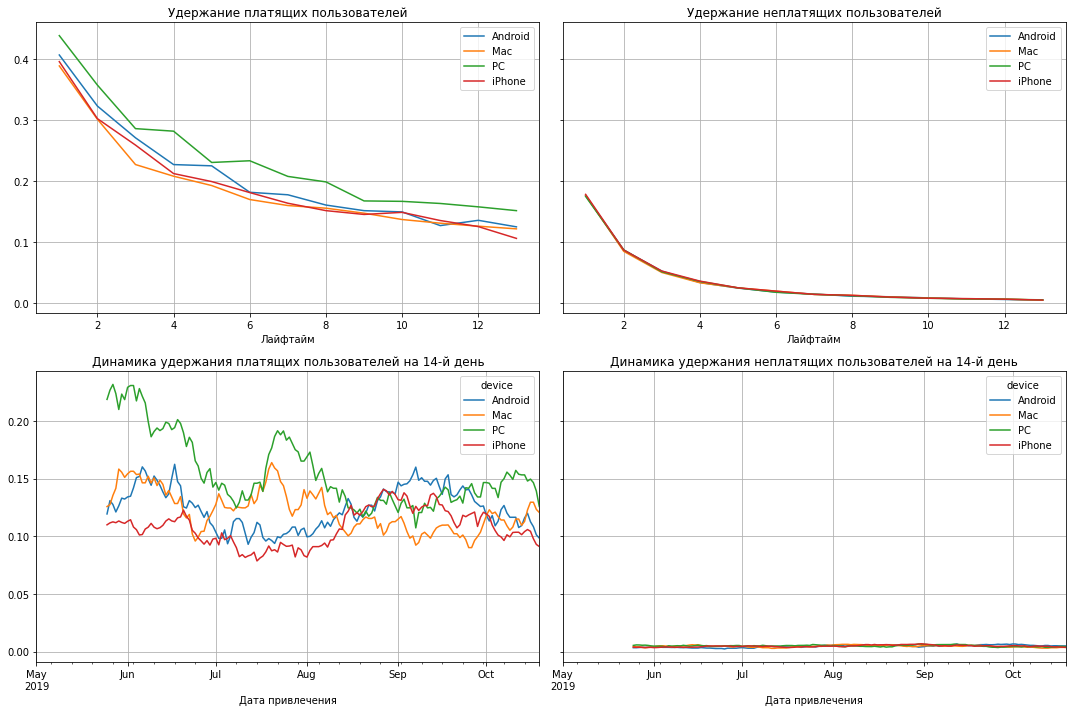

In [46]:
# разбивка удержания по устройствам
retantion_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_day,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)
plot_retention(retention, retention_history, horizon_days, window=25)

Из графиков видно:
* Удержание платящих пользователй ПК выше, чем у других платформ, удержание по которым примерно одинаковое.
* Динамика удержания платящих пользователей на 14 день после августа 2019 примерно одинаковая и стабильная - около 10-15%. В июне удержание платящих пользователей ПК было выше, чем у остальных платформ, около 23%, затем снизилась до 15%.
* Удержание неплатящих пользователей и динамика их удержания одинаковы для всех платформ. 

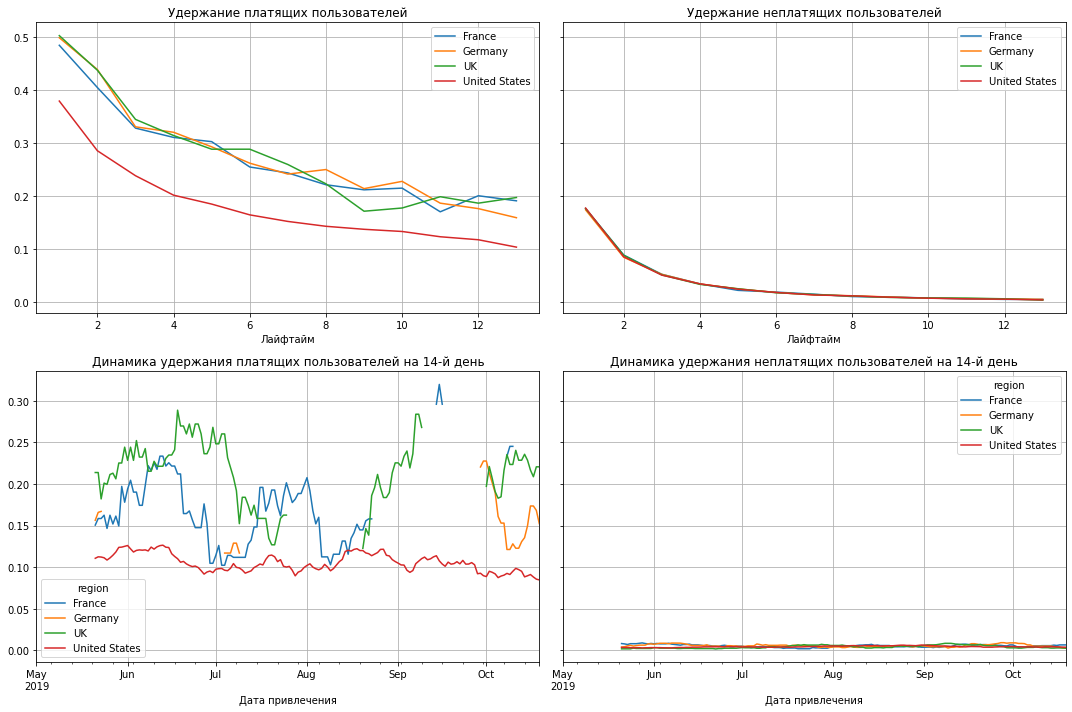

In [47]:
# разбивка удержания по странам
retantion_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_day,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)
plot_retention(retention, retention_history, horizon_days, window=21)

Из графиков видно:
* Удержание платящих пользователй из США ниже, чем из других стран. Удержание по Франции, Германии, Великобритании примерно одинаковое.
* Динамика удержания платящих пользователей на 14 день стабильная только для США - около 9-12%. Наблюдаются проблемы в данных для Франции, Германии, Великобритании. При сглаживании фрейма наблюдаются пропуски, это может быть связано с отсутствием данных по этим странам за рассматриваемый период. Имеющиеся данные показывают более высокое удержание по этим странам по сравнению с США.
* Удержание неплатящих пользователей и динамика их удержания одинаковы для всех платформ.

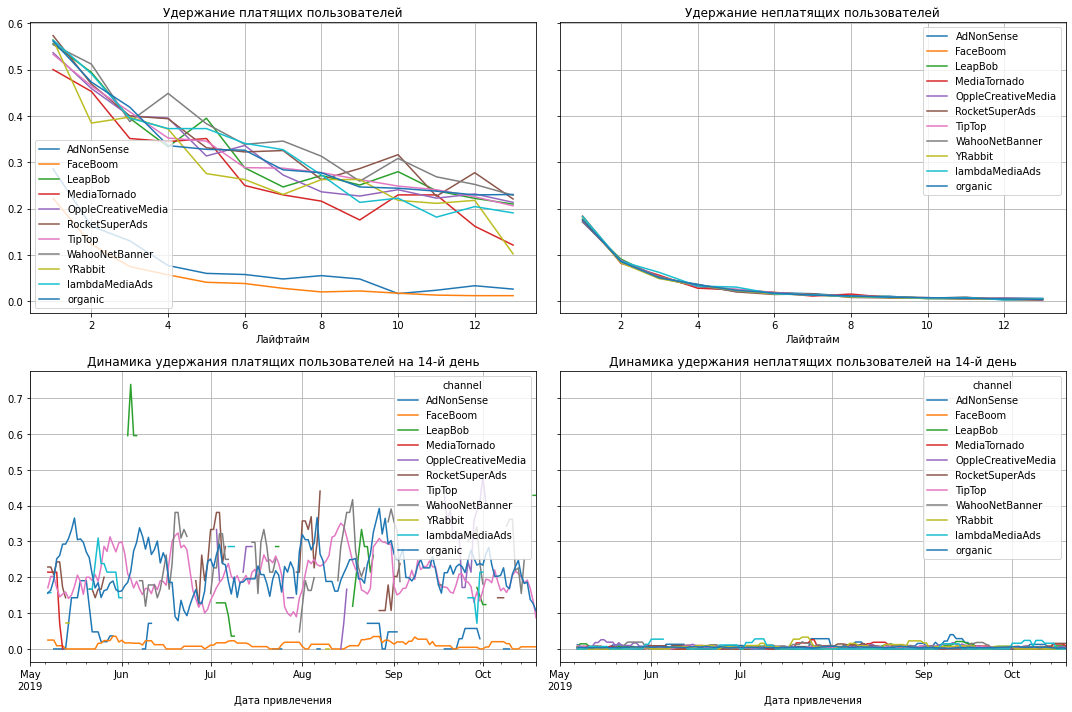

In [48]:
# разбивка удержания по рекламным каналам

retantion_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_day,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_retention(retention, retention_history, horizon_days, window=7)

Из графиков видно:

* Удержание платящих пользователй, пришедших из каналов FaceBoom и AdNonSense близки и значительно ниже (на 14 день - менее 5%), чем у других каналов(YRabbit около 10%, MediaTorando около 13%, остальные 20-25%).
* Динамика удержания платящих пользователей на 14 день стабильная только для FaceBoom - не превышает 5%. Наблюдаются проблемы в данных по остальным каналам. При сглаживании фрейма наблюдаются пропуски, это может быть связано с отсутствием данных по этим каналам за рассматриваемый период. Имеющиеся данные показывают более высокое удержание по этим каналам по сравнению с FaceBoom. Данные находятся в коридоре 10-40%.
* Удержание неплатящих пользователей и динамика их удержания одинаковы для всех каналов.

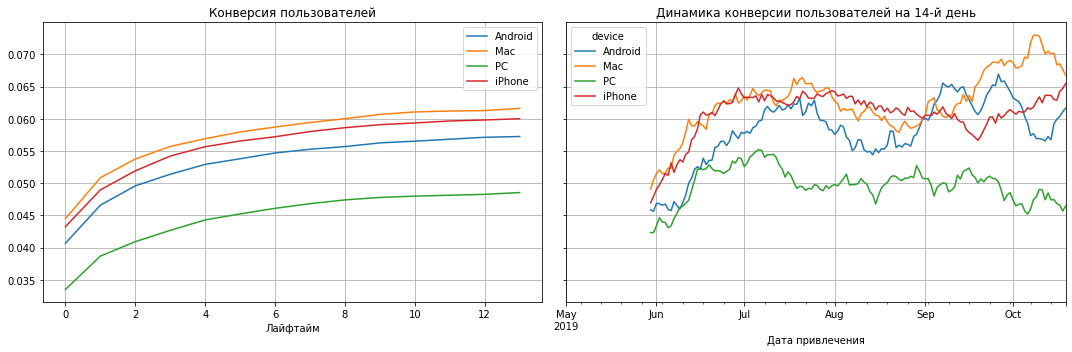

In [49]:
# графики конверсии пользователей по устройствам

conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_day,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)
plot_conversion(conversion, conversion_history, horizon_days, window=30)

Из графиков видно:
* Профиль конверсии пользователей для всех платформ имеет типичный вид экспоненциальной зависимости. Наибольшая конверсия на 14 день среди пользователей Mac (около 6,2%), немного отстают iPhone и Android (6% и 5,7% соответственно), наименьшая - среди PC (около 4,8%).
* Динамика конверсии пользователей на 14 день с начала июня (менее 5%) показывает небольшой рост по всем платформам на 1-1,5%. Для платформ Android, Mac и iPhone в целом конверсия держится стабильно до конца октября не опускаясь ниже 5,5%, для PC наблюдается спад почти до июньских значений.

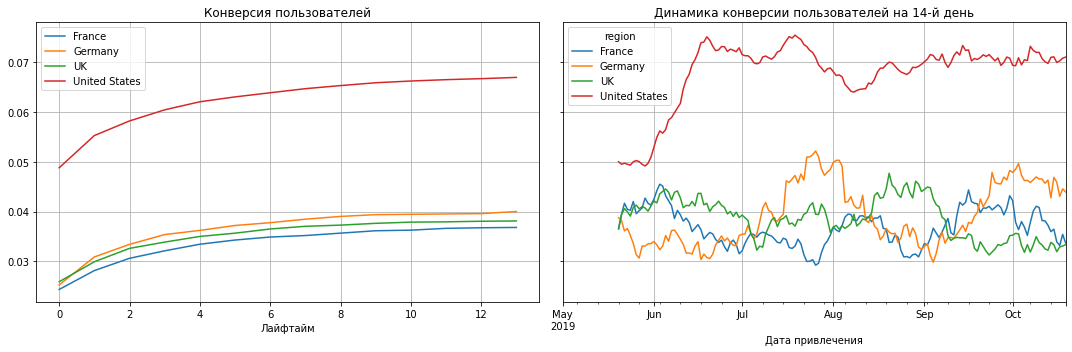

In [50]:
# графики конверсии пользователей по странам

conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_day,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)
plot_conversion(conversion, conversion_history, horizon_days, window=20)

Из графиков видно:
* Высокую конверсию показывают пользователи из США. Также виден явный рост конверсии с начала июня с 5% до ~7%. Динамика конверсии пользователей с июля во всех странах достаточно стабильна.
* Конверсии пользователей по Франции, Германии и Великобритании сопоставимы и не превышают 4% к 14 дню.

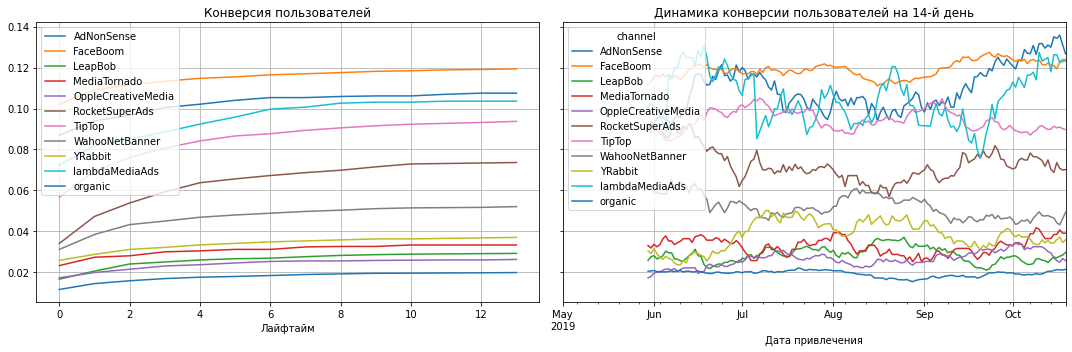

In [51]:
# графики конверсии пользователей по каналам

conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_day,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)
#conversion = conversion.query('channel != "organic"') # строка для отличия AdNonSense и organic
plot_conversion(conversion, conversion_history, horizon_days, window=30)

Из графиков видно:
* Наибольшей конверсией обладают пользователи из канала FaceBoom (12%), затем AdNonSense (около 11%) и третий - lambdaMediaAds (около 10,5%). Один из самых высокозатратных каналов TipTop только на 4-м месте с конверсией около 9,2%. Наименьшая конверсия среди пользователей, которые сами нашли программу.
* Конверсия пользователей по датам привлечения стабильна для всех каналов, амплитуда колебаний не превышает 1%.

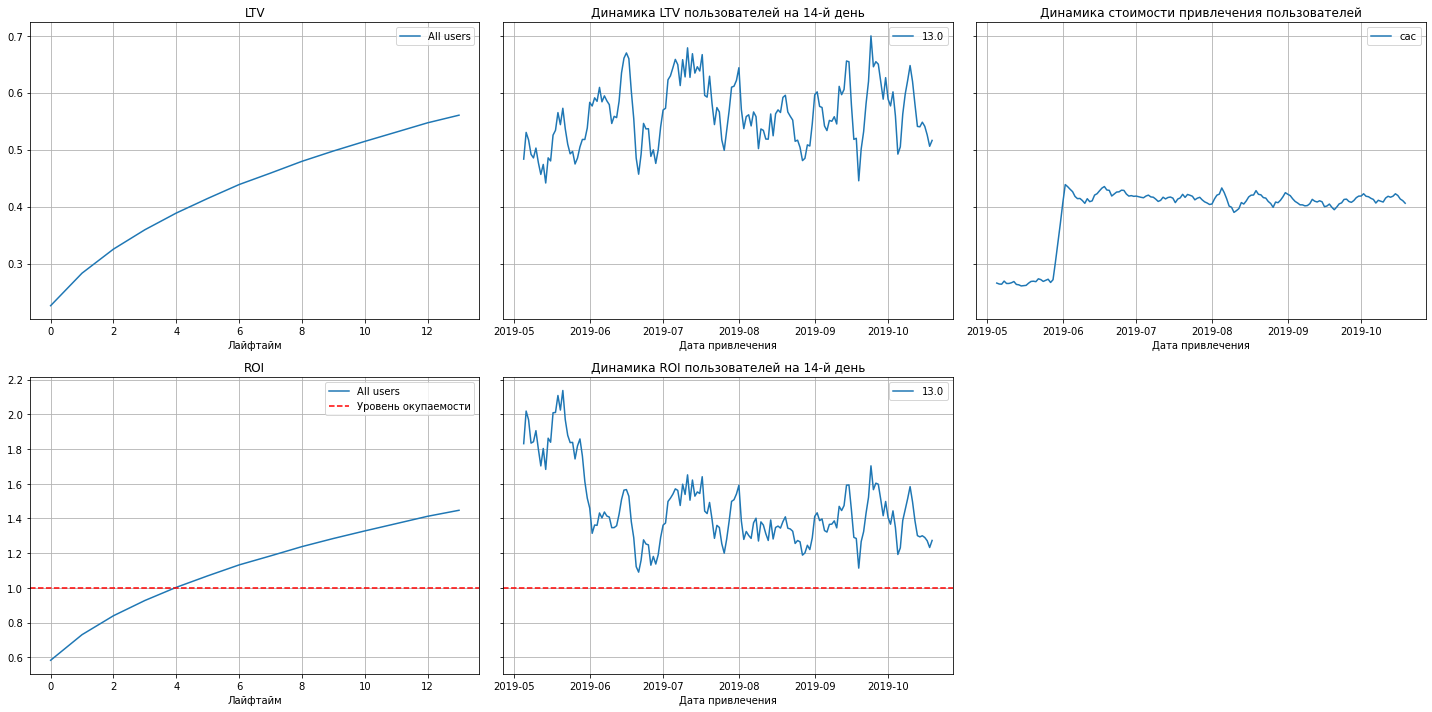

In [52]:
# вспомогательные графики для оценки рекламных кампаний без канала TipTop

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "TipTop"'),
    orders,
    observation_day,
    horizon_days,
    dimensions=[],
    ignore_horizon=False)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=5)

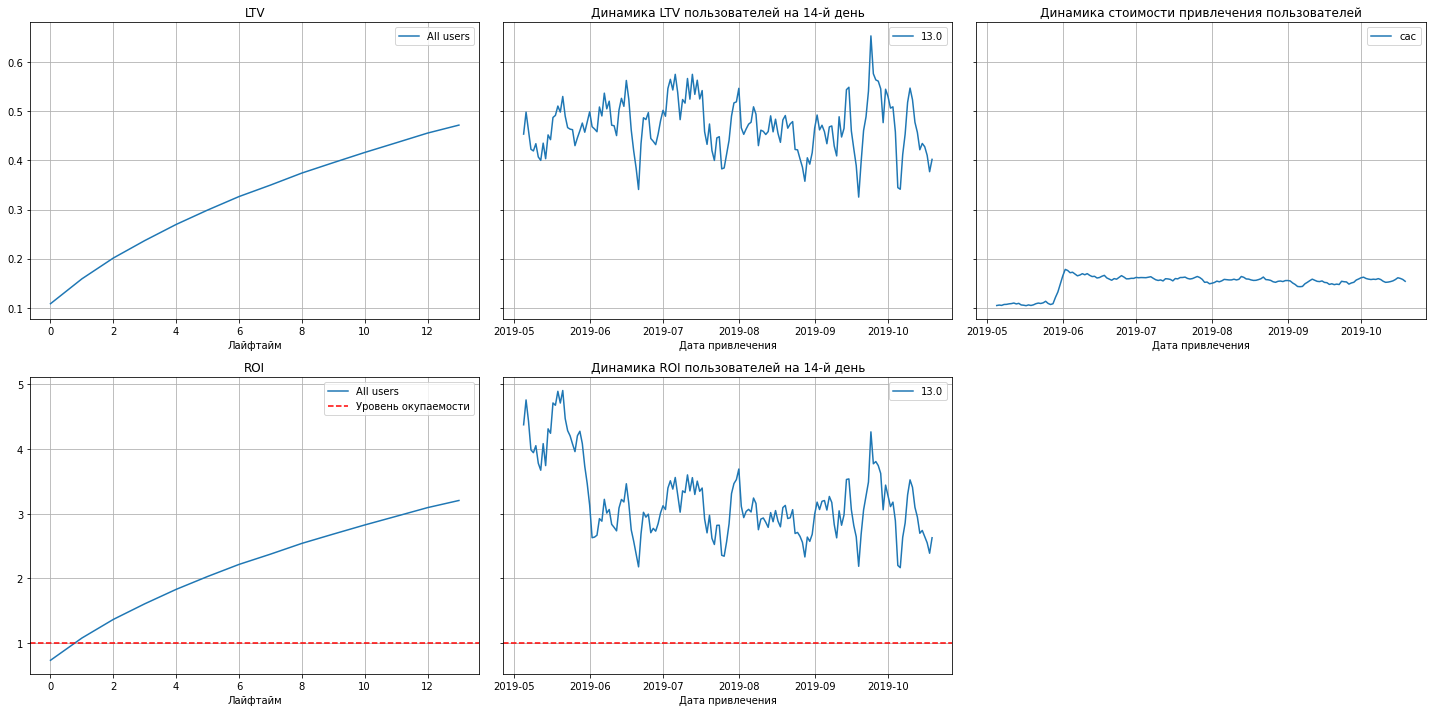

In [53]:
# вспомогательные графики для оценки рекламных кампаний без каналов TipTop, FaceBoom и AdNonSense

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "TipTop" and channel != "FaceBoom" and channel != "AdNonSense"'),
    orders,
    observation_day,
    horizon_days,
    dimensions=[],
    ignore_horizon=False)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=5)

**В целом реклама не окупается.**\
Анализ графиков показал, что канал TipTop хоть и второй по количеству привлечённых платящих пользователей, реклама в нём обходится слишком дорого и привлечённые пользователи не окупаются, причем настолько, что умаляет положительные результаты привлечения пользователей через остальные каналы.\
Также под подозрением на неэффективное расходование средств находятся каналы FaceBoom и AdNonSense. FaceBoom занимает первое место по количеству привлеченных платящих пользователей и второе по величине бюджета на рекламу. Траты по ним так и не окупились. Также они показывают низкое удержание платящих пользователей. \
\
Если построить графики общих значений LTV и ROI без учета канала TipTop, общая картина совершенно меняется: пользователи окупаются на 5 день, а затраты на рекламные кампании меньше и стабильны в течении исследуемого периода.\
Если исключить из анализа ещё FaceBoom и AdNonSense, то из графиков становится видно, что остальные каналы окупают вложенные затраты уже на второй день.\
Проблема окупаемости кроется в высокой стоимости размещения рекламы в каналах TipTop, FaceBoom и AdNonSense.\
\
Используемая платформа устройств пользователей не влияет на окупаемость рекламы.

# **6. Выводы**
## 6.1. Возможные причины неэффективности привлечения пользователей.
Анализ данных показал, что возможными причинами неэффективности привлечения пользователей является её высокая стоимость в каналах TipTop, FaceBoom, а для каналов FaceBoom и AdNonSense ещё и низкий уровень удержания платящих пользователей.
## 6.2. Рекомендации для отдела маркетинга.
Для повышения эффективности проводимых рекламных кампаний стоит обратить внимание на каналы TipTop, FaceBoom и AdNonSense, оценить целесообразность дальнейшей работы с ними. Траты на TipTop и FaceBoom слишком высоки. Количество привлеченных пользователей из этих каналов и стоимость их заказов не покрывают затраты на их привлечение.\
Вероятно, стоит обратить внимание на целевые аудитории этих каналов, конверсия по ним недостаточна.\
Анализ показал, что каналы, где стоимость привлечения одного пользователя составляет менее 1, окупаются в необходимые две недели.\